# CoughSultant: A Covid-19 detection tool based on cough recordings
### Final Project for CS-577 (Machine Learning) fall semester 2022 - 2023
### University of Crete, Computer Science Department

## By: Ioannis Kaziales - csdp1305



In this file, I use the dataset created using `data_exploration.ipynb`, perform some preprocessing (dropping some columns, encoding categorical features and labels) to get the final dataset and train a machine learning model for multiclass classification (`healthy`, `symptomatic` and `COVID-19`). Specifically, I perform feature selection and grid search cross validation to finetune the model. I then estimate the model score (ROC-AUC) on a hold-out set and return the final model, trained on all the data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# classifiers
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

%load_ext jupyternotify

<IPython.core.display.Javascript object>

First, let's load the dataset and do some preprocessing. Encode the `gender` ('female', 'male', 'other') with one-hot encoding and encode the label `status`.

In [2]:
dataset_file = './dataset.csv'

df = pd.read_csv(dataset_file)
df = df.drop(['uuid', 'cough_detected'], 1)
# gender is nominal feature -> one hot encoding
df = pd.get_dummies(df,prefix=['gender'], columns = ['gender'])
df = df[list(df.columns)[-3:] + list(df.columns)[:-3]]
# status can be considered ordinal (healthy < symptomatic < COVID-19) -> label encoding
encoder = LabelEncoder()
df['status'] = encoder.fit_transform(df['status'])

df.to_csv("final_dataset.csv", index=False)

/tmp/ipykernel_23735/4277701535.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop(['uuid', 'cough_detected'], 1)


In [3]:
df

,gender_female,gender_male,gender_other,age,respiratory_condition,fever_muscle_pain,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,...,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp,status
0,0,1,0,15.0,False,False,29.147787,0.143020,24.347471,28.681740,...,-0.000141,3.825115,3.125000,4.494382,0.057500,0.038971,0.145000,0.110793,-18.483364,1
1,0,1,0,34.0,True,False,27.316082,0.259979,23.518070,26.094170,...,-0.000563,0.805896,1.336303,3.611738,0.161250,0.148949,0.106429,0.113049,-16.352827,1
2,0,1,0,21.0,False,False,40.342415,0.297468,26.237854,39.531647,...,0.008399,1.579487,4.166667,4.294478,0.108571,0.108157,0.101429,0.096129,-18.965321,1
3,0,1,0,20.0,True,False,35.748589,0.225012,27.347082,36.506306,...,0.020177,3.073178,1.250000,2.666667,0.175000,0.125000,0.116667,0.069442,-21.783979,1
4,1,0,0,28.0,False,False,42.199139,0.025911,41.479694,42.611164,...,0.016175,1.196734,2.469136,2.666667,0.125000,0.095000,0.230000,0.040000,-17.277319,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15287,0,1,0,26.0,False,False,35.191689,0.465942,15.873823,34.427540,...,-0.002652,0.481736,1.855288,4.307117,0.114783,0.177810,0.087200,0.054297,-16.800301,1
15288,0,1,0,23.0,False,False,47.121445,0.053890,44.593990,46.509430,...,0.025201,0.017307,1.639344,1.785714,0.060000,0.000000,0.235000,0.015000,-60.949707,1
15289,1,0,0,22.0,False,False,34.241447,0.323004,20.641817,35.963646,...,0.005841,0.233061,1.097695,1.655629,0.069333,0.058134,0.549286,0.785361,-26.655272,1
15290,0,1,0,21.0,True,False,42.202671,0.249178,28.868713,45.117577,...,0.000638,0.674118,1.724138,2.923977,0.126000,0.119516,0.177273,0.132053,-23.378725,1


Let's split our data to train and hold-out sets.

In [5]:
r_st = 1305  # random state for reproducibility
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=r_st, test_size=0.15, stratify=y)

In [6]:
X_test

,gender_female,gender_male,gender_other,age,respiratory_condition,fever_muscle_pain,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
8194,1,0,0,30.0,False,False,41.162727,0.213204,32.611885,41.342907,...,0.123085,0.011406,1.779027,3.174603,2.834008,0.194286,0.339531,0.135714,0.120102,-12.746344
3777,0,1,0,28.0,True,False,31.995464,0.195843,27.907618,30.308714,...,0.075387,-0.008658,0.944234,2.448980,2.928870,0.154286,0.147247,0.161429,0.085261,-17.638897
9590,0,1,0,19.0,False,False,38.678249,0.210466,31.187130,39.253544,...,0.127385,0.013291,0.699507,1.932367,4.455446,0.090000,0.079162,0.127500,0.117447,-20.988085
13052,0,1,0,44.0,False,False,42.657753,0.265659,30.185104,44.335922,...,0.147309,0.007290,0.149840,3.333333,3.414634,0.152857,0.168329,0.135000,0.097254,-33.088593
6890,0,1,0,58.0,False,False,27.761177,0.545999,16.900890,21.395170,...,0.055965,0.006370,1.194248,1.652893,1.265823,0.120000,0.098995,0.485000,0.250849,-20.168209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5687,0,1,0,34.0,False,False,40.018269,0.272000,30.743805,42.592014,...,0.114714,0.015973,3.833260,4.761905,1.652893,0.355000,0.085000,0.150000,0.088318,-13.805756
12353,0,1,0,40.0,True,False,39.799721,0.415622,17.530708,44.326351,...,0.094077,0.011790,0.099718,2.059732,3.008299,0.106207,0.083021,0.267727,0.481106,-29.488804
7506,1,0,0,28.0,False,True,38.592686,0.250323,32.038231,40.536633,...,0.108844,0.003780,0.227424,1.023541,2.892562,0.145357,0.131814,0.184444,0.297886,-22.799145
8591,0,1,0,42.0,True,False,41.391800,0.222717,35.054008,40.508961,...,0.076976,-0.002810,0.744180,1.734694,2.366255,0.112174,0.101251,0.316190,0.464681,-14.032256


We can visualize the correlation between the features

<AxesSubplot: >

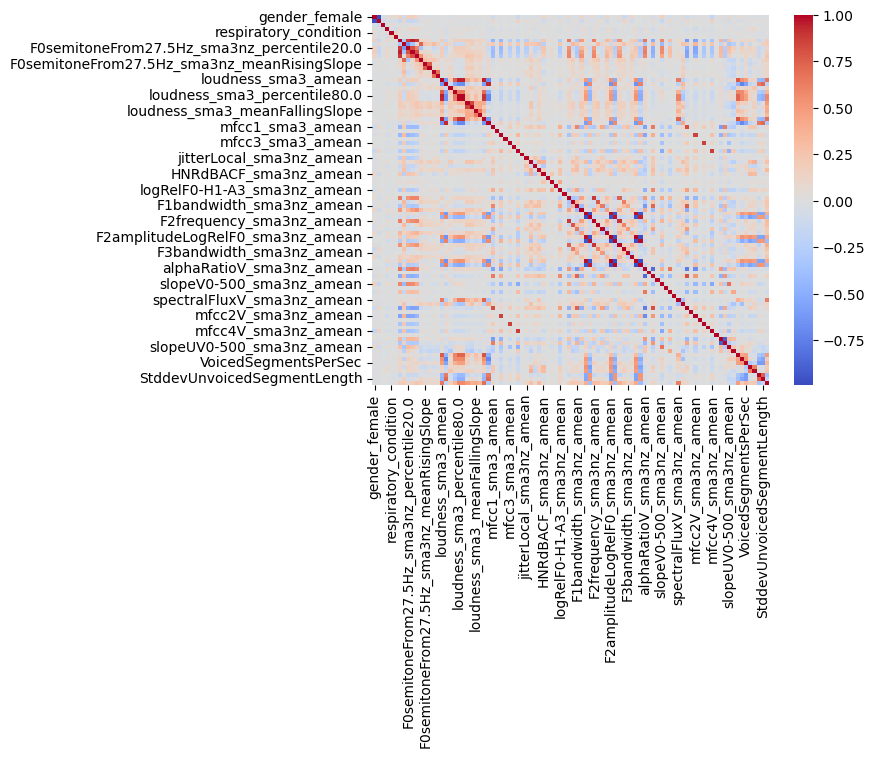

In [7]:
#plt.subplots(figsize=(10,10)) 
sns.heatmap(X.corr(), cmap='coolwarm')
#plt.savefig('correlation.png')

## Feature Selection
Now, let's perform feature selection (Sequential (forward) feature selection)

In [8]:
%%notify

model = KNeighborsClassifier(n_neighbors=5)

sfs = SFS(model, 
           k_features='best', 
           forward=True, 
           floating=False, 
           verbose=0,
           scoring='roc_auc_ovr_weighted',
           n_jobs=-1,
           cv=5)


sfs = sfs.fit(X_train, y_train)

<IPython.core.display.Javascript object>

In [10]:
# The selected features
selected = X_train.columns[1:][list(sfs.k_feature_idx_)]

X_train_selected = pd.DataFrame(sfs.transform(X_train), columns=selected)
X_test_selected = pd.DataFrame(sfs.transform(X_test), columns=selected)

Let's visualize the selected features.

In [11]:
print(f"Out of {len(X_train.columns)} original features, {len(selected)} were selected")
print("selected features:")
for feat in selected:
    print(f" - {feat}")

Out of 94 original features, 12 were selected
selected features:
 - gender_male
 - gender_other
 - age
 - respiratory_condition
 - fever_muscle_pain
 - F0semitoneFrom27.5Hz_sma3nz_amean
 - loudness_sma3_percentile50.0
 - F2bandwidth_sma3nz_amean
 - alphaRatioV_sma3nz_amean
 - slopeV0-500_sma3nz_stddevNorm
 - slopeV500-1500_sma3nz_stddevNorm
 - spectralFluxUV_sma3nz_amean


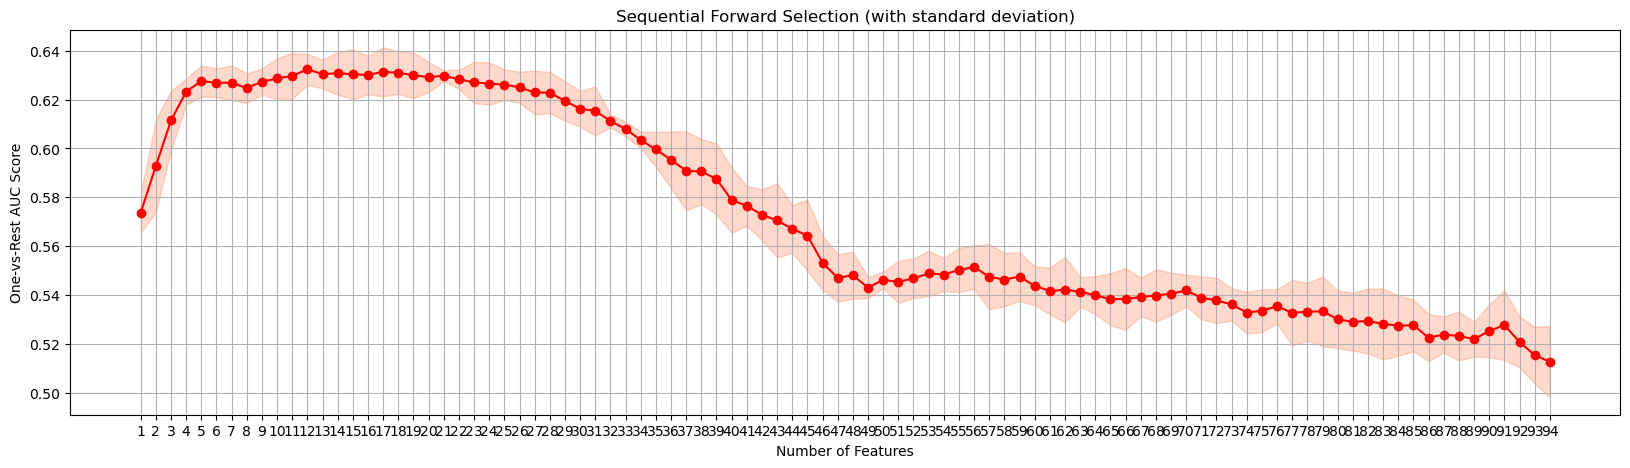

In [12]:
metric_dict = sfs.get_metric_dict(confidence_interval=0.95)
fig1 = plot_sfs(metric_dict, figsize=(20,5), kind='std_dev', color='red', bcolor='orangered', ylabel='One-vs-Rest AUC Score')

plt.title('Sequential Forward Selection (with standard deviation)')
plt.grid()
plt.show()

## Identifying the best configuration
Now, we will use grid search cross validation to identify the best hyperparameters for the best model.

In [13]:
# Initialze the estimators
clf1 = RandomForestClassifier(random_state=r_st)
clf2 = SVC(probability=True, random_state=r_st)
clf3 = KNeighborsClassifier()
clf4 = GradientBoostingClassifier(random_state=r_st)

param1 = {'classifier':[clf1], 'classifier__n_estimators':[10, 50, 100, 250], 'classifier__max_depth':[5, 10, 20],
          'classifier__class_weight':[None, 'balanced']}

param2 = {'classifier':[clf2], 'classifier__C':[10**-2, 10**-1, 10**0, 10**1, 10**2],
         'classifier__class_weight':[None, 'balanced'], 'classifier__kernel':['linear', 'poly', 'rbf']}

param3 = {'classifier':[clf3], 'classifier__n_neighbors':[3, 5, 7, 10, 20],
         'classifier__weights':['uniform', 'distance']}

param4 = {'classifier':[clf4], 'classifier__n_estimators':[10, 50, 100, 250],
         'classifier__max_depth':[5, 10, 20]}

In [14]:
pipeline = Pipeline([('classifier', clf1)])
params = [param1, param2, param3, param4]

In [15]:
%%notify
gs = GridSearchCV(pipeline, params, cv=3, n_jobs=-1, scoring='roc_auc_ovr_weighted').fit(X_train_selected, y_train)

<IPython.core.display.Javascript object>

In [16]:
print(f"Best performing model:\n{gs.best_params_['classifier']}")
print(f"Best One-vs-rest ROC-AUC score from cross-validation: {gs.best_score_:.3f} (optimistic estimate)")

Best performing model:
RandomForestClassifier(max_depth=5, random_state=1305)
Best One-vs-rest ROC-AUC score from cross-validation: 0.696 (optimistic estimate)


In order to get a more accurate estimate of the accuracy, I will now train just the best model on all the training data and test its performance on the hold-out set.

In [37]:
print("Training the best model on all the training data...")
model = gs.best_params_['classifier']
model.fit(X_train_selected, y_train)

print("Evaluating the model performance on the hold-out set...")
y_pred = model.predict_proba(X_test_selected)
print(f"One-vs-rest ROC-AUC estimate on hold-out: {roc_auc_score(y_test, y_pred, multi_class='ovr'):.3f} (conservative estimate)") 
print(f"Weighted One-vs-rest ROC-AUC estimate on hold-out: {roc_auc_score(y_test, y_pred, multi_class='ovr', average='weighted'):.3f} (conservative estimate)") 

Training the best model on all the training data...
Evaluating the model performance on the hold-out set...
One-vs-rest ROC-AUC estimate on hold-out: 0.690 (conservative estimate)
Weighted One-vs-rest ROC-AUC estimate on hold-out: 0.703 (conservative estimate)


Let's plot the One-vs-Rest ROC curves now and find the confusion matrix

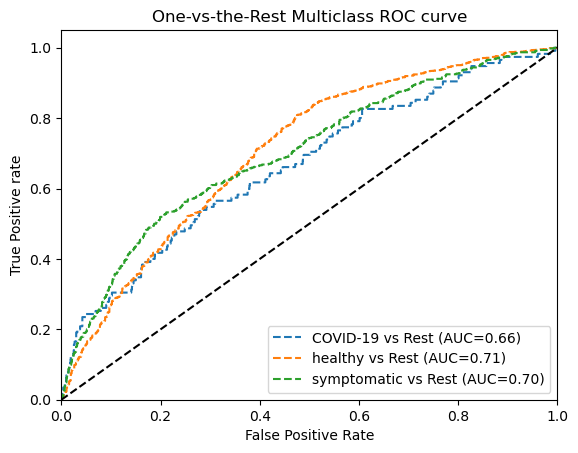

In [38]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np

#binarize the y_values
y_test_binarized=label_binarize(y_test, classes=np.unique(y_test))

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}
roc_auc = dict()

classes=encoder.classes_
n_class = classes.shape[0]

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test_binarized[:,i], y_pred[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    # plotting    
    plt.plot(fpr[i], tpr[i], linestyle='--', 
             label='%s vs Rest (AUC=%0.2f)'%(classes[i],roc_auc[i]))

plt.plot([0,1],[0,1],'k--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.title('One-vs-the-Rest Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='lower right')
#plt.savefig('roc.png')
plt.show()

In [39]:
y_pred = np.argmax(y_pred, axis=1)

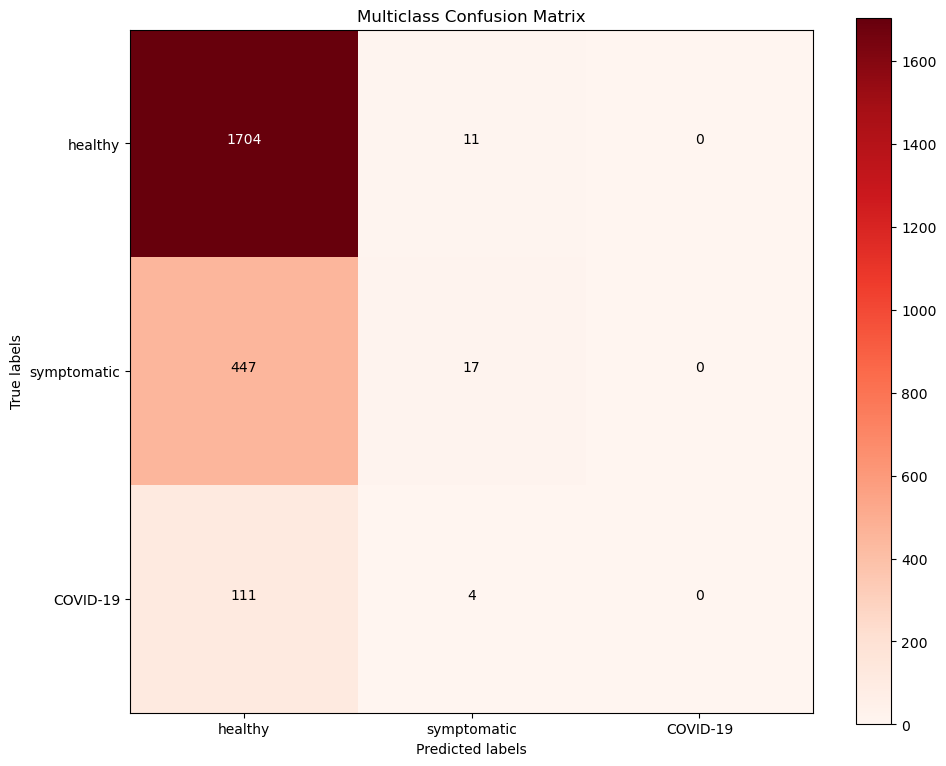

In [45]:
from sklearn.metrics import confusion_matrix
n_classes = len(np.unique(y_test)) # number of classes

# calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=y_test.unique())

# plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
plt.imshow(cm, cmap='Reds')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, encoder.classes_[y_test.unique()])
plt.yticks(tick_marks, encoder.classes_[y_test.unique()])
plt.grid(False)
plt.title('Multiclass Confusion Matrix')

# add values to each cell of the heatmap
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
#plt.savefig('confusion.png')
plt.show()

Finally, train the final model on all the data:

In [46]:
# The selected features
X_selected = sfs.transform(X)
print("Training the final model (the one to be returned) on all the data...")
model = GradientBoostingClassifier(max_depth=5, n_estimators=10, random_state=r_st)
model.fit(X_selected, y)

Training the final model (the one to be returned) on all the data...


GradientBoostingClassifier(max_depth=5, n_estimators=10, random_state=1305)